# COMP5329 - ASSIGNMENT 2 - PHASE 1 - CNN FOR IMAGES

## Instructions for running the code

To run the code, please run each individual cell sequentially. To do this, you can manually run each cell, or you can choose to run all cells sequentially automatically by pressing CMD+F9 (MAC) or CTRL+F9 (PC).

The third code cell in the sheet downloads the relevant data from Google Drive. When this cell is run, you will need to give Google Colab permission to access Google Drive. After this, all cells will run without any further input needed from your side.


## 0 Importing Packages

In [ ]:
import os
import csv
import re
import numpy as np
import pandas as pd
from io import StringIO
from sklearn.model_selection import train_test_split

%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
from datetime import timedelta
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

torch.__version__

'2.0.0+cu118'

## 1 Data Loading
Define dataloaders and conduct sanity check (we need to ensure the images and the labels are paired).

Specify if we are using GPU.

In [ ]:
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')

We are using GPU.


### 1.1 loading train data and no-label test data as well as kaggle token to download the images

In [ ]:
# Give Google Colab access to files on your drive
from google.colab import drive
drive.mount('/content/gdrive')

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


id = '1Zl_dPreldqoN3ngq6UXFNGC8_7WYPmBg'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('kaggle.json')

#importing kaggle token and downloading data
!mkdir ~/.kaggle

!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c multi-label-classification-competition-2023
!unzip multi-label-classification-competition-2023.zip > /dev/null
print('Zip file extracted successfully.')

Mounted at /content/gdrive
 98% 389M/399M [00:04<00:00, 117MB/s]
100% 399M/399M [00:04<00:00, 94.5MB/s]
Zip file extracted successfully.


In [ ]:
### Train data
FILENAME = '/content/COMP5329S1A2Dataset/train.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

### Test data
FILENAME = '/content/COMP5329S1A2Dataset/test.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
no_label_test_df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

creating all_data , train and test dataframes with one-hot encoded labels

In [ ]:
# Add a column for each label.
# A "1" indicates that the label applies for that example.
for i in list(range(1,20)):
    df["Label"+str(i)] = df["Labels"].apply(lambda x: 1 if str(i) in x.split() else 0)

# Create a validation set
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0)

df_train = df_train.reset_index()
df_test = df_test.reset_index()

df_total=df.copy()
df_total.head()

,ImageID,Labels,Caption,Label1,Label2,Label3,Label4,Label5,Label6,Label7,...,Label10,Label11,Label12,Label13,Label14,Label15,Label16,Label17,Label18,Label19
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.jpg,1 19,A couple of men riding horses on top of a gree...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.jpg,1,They are brave for riding in the jungle on tho...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### 1.2 Defining Dataloaders

creating list of images and their lables 

In [ ]:
source_folder = '/content/COMP5329S1A2Dataset/data'

data_train=[]
for idx in range(len(df_train)):
  img_id = df_train.loc[idx,"ImageID"]
  img_path = os.path.join(source_folder, img_id)
  label_vector= list(df_train.loc[idx,['Label1', 'Label2', 'Label3', 'Label4', 'Label5','Label6', 'Label7',
                                       'Label8', 'Label9', 'Label10', 'Label11','Label12', 'Label13',
                                       'Label14', 'Label15','Label16', 'Label17', 'Label18', 'Label19']])
  data_train.append((img_path,label_vector))

data_test=[]
for idx in range(len(df_test)):
  img_id = df_test.loc[idx,"ImageID"]
  img_path = os.path.join(source_folder, img_id)
  label_vector= list(df_test.loc[idx,['Label1', 'Label2', 'Label3', 'Label4', 'Label5','Label6', 'Label7',
                                       'Label8', 'Label9', 'Label10', 'Label11','Label12', 'Label13',
                                       'Label14', 'Label15','Label16', 'Label17', 'Label18', 'Label19']])
  data_test.append((img_path,label_vector))


### after doing all the experiments we run the model on all data set and then get the predictions for private dataset, so data_total will be used there
data_total=[]
for idx in range(len(df_total)):
  img_id = df_total.loc[idx,"ImageID"]
  img_path = os.path.join(source_folder, img_id)
  label_vector= list(df_total.loc[idx,['Label1', 'Label2', 'Label3', 'Label4', 'Label5','Label6', 'Label7',
                                       'Label8', 'Label9', 'Label10', 'Label11','Label12', 'Label13',
                                       'Label14', 'Label15','Label16', 'Label17', 'Label18', 'Label19']])
  data_total.append((img_path,label_vector))

here we define a class to create dataset from list of images and their labels

In [ ]:
class MultiLabelImageDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
    
    def __getitem__(self, index):
        img_path, label = self.data_list[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)
    
    def __len__(self):
        return len(self.data_list)

# Transform the data such that the image is of size 224x224, 
# that it is a tensor, and that the data is normalized
transform = transforms.Compose([
    transforms.Resize((224,224)), # Resize the image to 224x224
    transforms.ToTensor(), # Convert the image to a PyTorch tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # Normalize the image with mean and std
])

In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
kwargs['batch_size'] = 128  # Batch size used during training.

In [ ]:
dataset_train = MultiLabelImageDataset(data_train, transform=transform)
train_loader = DataLoader(dataset_train, shuffle=True, **kwargs)

dataset_test = MultiLabelImageDataset(data_test, transform=transform)
test_loader = DataLoader(dataset_test, shuffle=True, **kwargs)


### after all the experiments when we want to train the model with all data we un-comment below lines and comment out above lines of this cell

# dataset_train = MultiLabelImageDataset(data_total, transform=transform)
# train_loader = DataLoader(dataset_train, shuffle=True, **kwargs)

In [ ]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))

26996
3000


### 1.3 Sanity Check of the Dataset

Print some basic information about the dataset.

In [ ]:
print('{} examples in the training set.'.format(len(train_loader) * 128))


b_imgs, b_labels = next(iter(train_loader))
print('A batch of imgs shape:', b_imgs.size())
print('A batch of labels shape:', b_labels.size())
print('label batch:', b_labels)

27008 examples in the training set.
A batch of imgs shape: torch.Size([128, 3, 224, 224])
A batch of labels shape: torch.Size([128, 19])
label batch: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])


Show some images and labels to ensure they are paired.

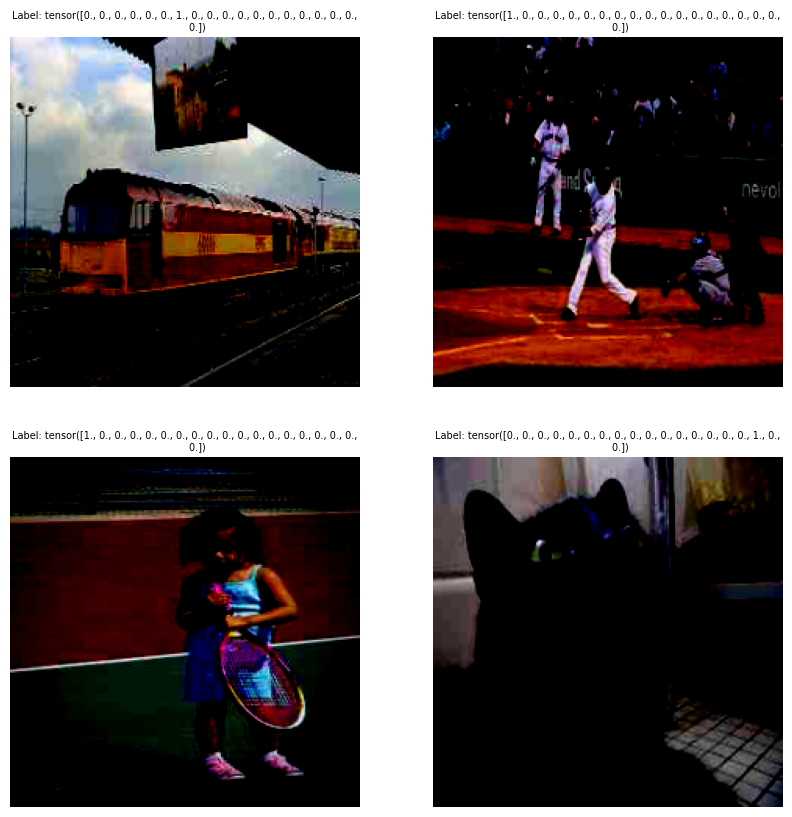

In [ ]:
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(b_imgs[i].permute(1,2,0))
    plt.axis('off')
    plt.title(f"Label: {b_labels[i]}" , fontsize=7)
plt.show()

## 2 Model Definition

Models defined using PyTorch toolkit should be a class inheriting from `torch.nn.Module`.

In [ ]:
torch.cuda.empty_cache()

import torchvision.models as models
import torch.nn as nn

model = models.resnet34(weights='DEFAULT')

num_classes = 19 # number of classes in your dataset
in_features = model.fc.in_features # get the number of input features for the fully connected layer
model.fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(512, num_classes)
)
model.sigmoid = nn.Sigmoid()

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)
print('Model initialized.')
print("Model size: {:.2f} MB".format(sum(p.numel() for p in model.parameters() if p.requires_grad) / (1024*1024)))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 394MB/s]


Model initialized.
Model size: 21.56 MB


In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224))

In [ ]:
ct = 0
for child in model.children():
  ct += 1
  print("Layer",ct,":", child)
  if ct < 10:
    for param in child.parameters():
        param.requires_grad = False

## 3 Train

In [ ]:
num_epochs = 30

import time
from sklearn.metrics import f1_score

start_time_all = time.time()
f1_test_list=[]

for epoch in range(num_epochs):
    start_time = time.time()

    # Training
    train_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        model.train()
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # Calculate training loss
        train_loss += loss.item()

        # Calculate accuracy
        predicted = (model.sigmoid(outputs) > 0.5).float()
        total += labels.size(0) * labels.size(1)
        # correct += (predicted == labels).sum().item()

        for i in range(labels.shape[0]):
          # print(a[i])
          if torch.where(predicted[i] == 1.0)[0].tolist() == torch.where(labels[i] == 1.0)[0].tolist():
            correct+=1

    # print(outputs)
    # print(model.sigmoid(outputs))
    # print(predicted)
    train_loss /= len(train_loader)
    accuracy = 100 * correct / total

    # Print statistics
    duration = (time.time() - start_time)/60
    print('[Epoch %d] Loss: %.3f, Accuracy: %.3f%%, Duration: %.3f minutes' %
          (epoch+1, train_loss, accuracy, duration))
    
    # Evaluate model performance on validation set
    model.eval()
    test_loss = 0
    test_accuracy = 0
    actual_class_cpu=[]
    predicted_class_cpu=[]
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            test_loss += labels.size(0)*criterion(model.sigmoid(outputs), labels).item()

            predicted = (model.sigmoid(outputs) > 0.23).float()

            for i in range(labels.shape[0]):
              # print(a[i])
              if torch.where(predicted[i] == 1.0)[0].tolist() == torch.where(labels[i] == 1.0)[0].tolist():
                test_accuracy+=1


            actual_class_cpu.append(labels.cpu().numpy())
            predicted_class_cpu.append(predicted.cpu().numpy())


    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)

    # Concatenate the tensors into numpy arrays
    predicted_class_cpu = np.concatenate(predicted_class_cpu)
    actual_class_cpu = np.concatenate(actual_class_cpu)
    f1_test = f1_score(predicted_class_cpu, actual_class_cpu, average='micro')

    # Print the results
    print('Test Loss: {:.4f}, Test Accuracy: {:.2%}, Test F1: {:.2%}'.format(test_loss, test_accuracy, f1_test))

    f1_test_list.append(f1_test)

end_time = time.time()-start_time_all
print(end_time)
print('Finished Training')



[Epoch 1] Loss: 0.148, Accuracy: 2.536%, Duration: 1.876 minutes
Test Loss: 0.6946, Test Accuracy: 45.67%, Test F1: 67.90%
[Epoch 2] Loss: 0.121, Accuracy: 2.782%, Duration: 1.910 minutes
Test Loss: 0.6928, Test Accuracy: 47.10%, Test F1: 69.81%
[Epoch 3] Loss: 0.114, Accuracy: 2.911%, Duration: 1.869 minutes
Test Loss: 0.6913, Test Accuracy: 49.47%, Test F1: 71.19%
[Epoch 4] Loss: 0.111, Accuracy: 2.965%, Duration: 1.885 minutes
Test Loss: 0.6896, Test Accuracy: 46.10%, Test F1: 71.65%
[Epoch 5] Loss: 0.109, Accuracy: 2.993%, Duration: 1.858 minutes
Test Loss: 0.6900, Test Accuracy: 49.50%, Test F1: 72.42%
[Epoch 6] Loss: 0.107, Accuracy: 3.027%, Duration: 1.873 minutes
Test Loss: 0.6875, Test Accuracy: 50.93%, Test F1: 73.64%
[Epoch 7] Loss: 0.104, Accuracy: 3.066%, Duration: 1.872 minutes
Test Loss: 0.6864, Test Accuracy: 50.57%, Test F1: 73.65%
[Epoch 8] Loss: 0.103, Accuracy: 3.075%, Duration: 1.946 minutes
Test Loss: 0.6893, Test Accuracy: 48.57%, Test F1: 72.80%
[Epoch 9] Loss: 

saving the model 

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/cnn_final_30epochs.pth')
torch.save(model, "/content/gdrive/MyDrive/cnn_final_30epochs.pt")

Evaluate performance of model per epoch of training

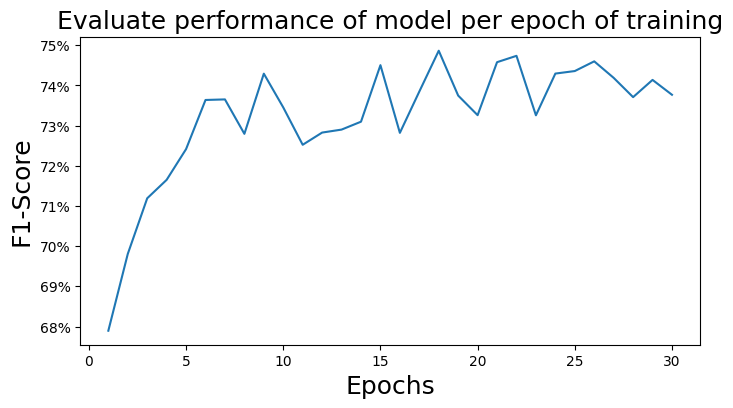

In [ ]:
x = [x for x in range(1, len(f1_test_list)+1)]
f1_test_list = [k*100 for k in f1_test_list]

import matplotlib.ticker as mtick

plt.figure(figsize=(8,4))
plt.plot(x, f1_test_list)
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("F1-Score", fontsize=18)
plt.title("Evaluate performance of model per epoch of training", fontsize=18)

plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter("%1.f"))

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(xticks)

plt.show()

## 4 Test

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

model.eval()
test_loss = 0
test_accuracy = 0
test_f1_score = 0
actual_class_cpu=[]
predicted_class_cpu=[]
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        test_loss += labels.size(0)*criterion(model.sigmoid(outputs), labels).item()

        predicted = (model.sigmoid(outputs) > 0.23).float()

        for i in range(labels.shape[0]):
          # print(a[i])
          if torch.where(predicted[i] == 1.0)[0].tolist() == torch.where(labels[i] == 1.0)[0].tolist():
            test_accuracy+=1


        actual_class_cpu.append(labels.cpu().numpy())
        predicted_class_cpu.append(predicted.cpu().numpy())


test_loss /= len(test_loader.dataset)
test_accuracy /= len(test_loader.dataset)


# Print the results
print('Test Loss: {:.4f}, Test Accuracy: {:.2%}'.format(test_loss, test_accuracy))

# Concatenate the tensors into numpy arrays
predicted_class_cpu = np.concatenate(predicted_class_cpu)
actual_class_cpu = np.concatenate(actual_class_cpu)
print('f1 score: ', f1_score(predicted_class_cpu, actual_class_cpu, average='micro'))
# print(classification_report(actual_class_cpu, predicted_class_cpu))

Test Loss: 0.6867, Test Accuracy: 50.30%
f1 score:  0.7376737673767376


## 5 getting results and label probabilities of private dataset

In [ ]:
data_test_private=[]
for idx in range(len(no_label_test_df)):
  img_id = no_label_test_df.loc[idx,"ImageID"]
  img_path = os.path.join(source_folder, img_id)
  data_test_private.append(img_path)

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image , image_path

dataset_test_private = ImageDataset(data_test_private, transform=transform)
private_test_loader = DataLoader(dataset_test_private, shuffle=False, **kwargs)
print(len(private_test_loader.dataset))

10000


In [ ]:
model.eval()

results=[]

with torch.no_grad():
    for i, (inputs, image_paths) in enumerate(private_test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = model.sigmoid(outputs)

        if i==0:
          probabilities_total =  probabilities
        else:
          probabilities_total = torch.cat((probabilities_total, probabilities), 0)

        predicted = (model.sigmoid(outputs) > 0.5).float()
    
        for i in range(len(inputs)):
            predicted_list=torch.where(predicted[i] == 1.0)[0].tolist()
            for j,val in enumerate(predicted_list):
              predicted_list[j]=val+1

            predicted_str= ' '.join(str(element) for element in predicted_list)
            results.append((image_paths[i].split('/')[-1],predicted_str))

In [ ]:
probabilities_total.shape

In [ ]:
probabilities_total = probabilities_total.tolist()

saving probabilities of private dataset as pkl file to combine with probabilities from LSTM

In [ ]:
import pickle

def save_pickle(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

save_pickle(probabilities_total, '/content/gdrive/MyDrive/probs_cnn_final_30epochs.pkl')

saving label prediction of private dataset  as a csv file

In [ ]:
results_df = pd.DataFrame(results , columns=['ImageID','Labels'])
results_df.head()
results_df.to_csv('/content/gdrive/MyDrive/results_cnn_final_30epochs.csv'  , index=False)